In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

from siv import SiVObject
plt.rcParams['font.size'] = 18

# Cavity Class

In [32]:
class Cavity:
    # References:
    # An integrated nanophotonic quantum register based on silicon-vacancy spins in diamond, Phys. Rev. B 100, 165428 (2019)
    # Cavity-based quantum networks with single atoms and optical photons, Rev. Mod. Phys.  87, 1379 (2015)
    
    def __init__(self, params=None):
        
        default_params = {
            # Atom parameters (units: s^-1)
            # Spin down (assume to be lower freq)
            "w_down" : 15,       # Spin-down transition frequency
            "g_down" : 5.6,       # Single-photon Rabi frequency
            "gamma_down" : 0.1,   # Transition linewidth / spont. emission rate

            # Spin up
            "w_up" : 17.5,          # Spin-up transition frequency
            "g_up" : 5.6,         # Single-photon Rabi frequency
            "gamma_up" : 0.1,      # Atom linewidth / spont. emission rate

            # Cavity parameters (units: s^-1)
            "w_c" : 0,    # Cavity resonance frequency
            "k_in" : 16.5,    # In-coupling mirror rate
            "k_out" : 0,   # Out-coupling mirror rate
            "k_tot" : 33,   # Cavity linewidth (k_tot = k_in + k_out + k_other)     
        }
        
        # Use the default parameters as a base for inputs that are not provided
        self.params = default_params.copy()
        if params is not None:
            self.params.update(params) # Update with user-input params
    
    def set_params(self, new_params):
        """ Update the instance params with a new set of params from a dictionary. """
        self.params.update(new_params)

    @staticmethod
    def reflectance_function(w, spin_state, w_down, g_down, gamma_down, w_up, g_up, gamma_up, w_c, k_in, k_out, k_tot):
        """ Reflectance as a function of laser frequency w. Used for curve fitting. """
        # From Rev. Mod. Phys.  87, 1379 (2015)
        # r_up = 1 - (2 * k_in / (1j * (w - w_c) + k_tot + g_up ** 2 / (1j * (w - w_up) + gamma_up)))
        # r_down = 1 - (2 * k_in / (1j * (w - w_c) + k_tot + g_down ** 2 / (1j * (w - w_down) + gamma_down)))
        
        # From Christian PRL Fig 2 fitting notebook
        # Differ by some factors of 2 from the above convention.
        r_up = 1 - (k_in / (1j * (w - w_c) + (k_tot/2) + g_up ** 2 / (1j * (w - w_up) + (gamma_up/2))))
        r_down = 1 - (k_in / (1j * (w - w_c) + (k_tot/2) + g_down ** 2 / (1j * (w - w_down) + (gamma_down/2))))
        R_up = (r_up * r_up.conjugate()).real
        R_down = (r_down * r_down.conjugate()).real
        return R_up if spin_state == 1 else R_down
        
    @staticmethod
    def transmittance_function(w, spin_state, w_down, g_down, gamma_down, w_up, g_up, gamma_up, w_c, k_in, k_out, k_tot):
        """ Transmittance as a function of laser frequency w. Used for curve fitting. """
        # From Rev. Mod. Phys.  87, 1379 (2015)
        t_up = 2 * np.sqrt(k_in * k_out) / (1j * (w - w_c) + k_tot + g_up ** 2 / (1j * (w - w_up) + gamma_up))
        t_down = 2 * np.sqrt(k_in * k_out) / (1j * (w - w_c) + k_tot + g_down ** 2 / (1j * (w - w_down) + gamma_down))
        T_up = (t_up * t_up.conjugate()).real
        T_down = (t_down * t_down.conjugate()).real
        return T_up if spin_state == 1 else T_down
        
    def reflectance(self, w, spin_state, params=None):
        """ Reflectance as a function of laser frequency w. Uses the instance parameters if None provided. """
        params = params if params is not None else self.params
        return Cavity.reflectance_function(w, spin_state, **params)
    
    def transmittance(self, w, spin_state):
        """ Transmittance as a function of laser frequency w. Uses the instance parameters if None provided. """
        params = params if params is not None else self.params
        return Cavity.transmittance_function(w, spin_state, **params)
    
    def fit_reflection(self, freqs, spectrum):
        """ Fit the reflection spectrum as a function of the laser frequency sweep (freqs). Returns the fitted parameters. """
        raise NotImplementedError
#         def lor(x, A1, x1, y1):
#             return A1/((x - x1)**2 + y1**2)
#         def f(x, x1, y1, x2, y2, x3, y3, A1, A2):
#             return 1 - (lor(x, A1, x1, y1) + lor(x, A2, x2, y2) + lor(x, A2, x3, y3))
#         params, covariance = curve_fit(f, freqs, spectrum)
#         return params
        # params, covariance = curve_fit(Cavity.reflectance_function, freqs, spectrum, p0=[1, 5.1, 1.2, 1.3, 1.25, 0.9, 2.5], maxfev=1000)
#         return dict(zip(["w_a", "g", "gamma", "w_c", "k_in", "k_out", "k_tot"], params))

# Replicate Fig 2b in PRL Nguyen 123 (2019)

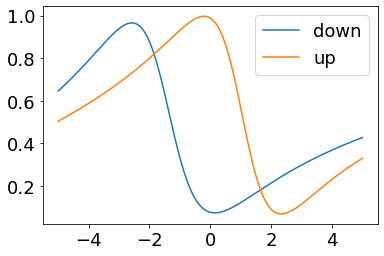

In [44]:
# Values taken from fitting notebook SSR Rabi.nb
c = Cavity({
            "w_down" : -2.53141,       
            "g_down" : 5.82265,       
            "gamma_down" : 0.1,   

            "w_up" : -0.205697,          
            "g_up" : 6.15004,         
            "gamma_up" : 0.01,    

            "w_c" : -12.6126,    
            "k_in" : 12.2252, 
            "k_tot" : 33.0766, 
})

w_arr = np.linspace(-5, 5, 1000)
plt.plot(w_arr, c.reflectance(w_arr, 0), label="down")
plt.plot(w_arr, c.reflectance(w_arr, 1), label="up")
plt.legend()

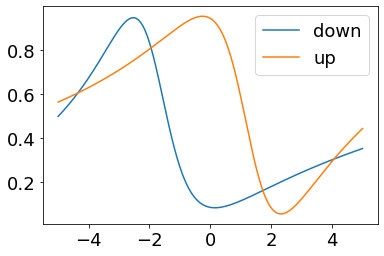

In [63]:
# Function and values taken from fitting notebook SSR Rabi (Mihir Bhaskar's conflicted copy 2019-03-20).nb
def t_function(w, w_a, delta, g, gamma, k, alpha, phi, B):
    t = np.sqrt(k) / (1j * (w - w_a - delta) + (k / 2) + g ** 2 / (1j * (w - w_a) + (gamma / 2))) + alpha * np.exp(1j * phi)
    return B * (t * t.conjugate()).real

w_arr = np.linspace(-5, 5, 1000)
plt.plot(w_arr, t_function(w=w_arr, w_a=-2.61589, delta=-8.56955, g=5.27, gamma=0.1, k=33.1, alpha=-0.26693, phi=-0.0636794, B=14.3136), label="down")
plt.plot(w_arr, t_function(w=w_arr, w_a=2.03911, delta=7.77476, g=5.27, gamma=0.1, k=33.1, alpha=-0.115794, phi=2.39099, B=4.95673), label="up")
plt.legend()

# SiV Class Energy Plotting Test

54.70831746635972


D:\Qi\Documents\Research\Codes\cQED Model\siv.py:240: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


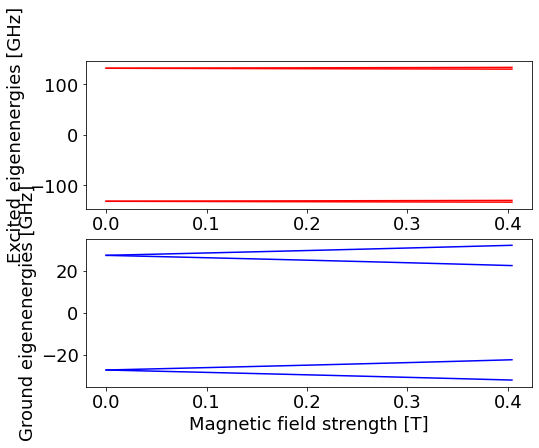

In [4]:
s = SiVObject()

# Sweep across Z field 
B_sweep = np.zeros([3,40])
B_sweep[0,:] = np.linspace(0.00, 0.7/np.sqrt(3), 40)
B_sweep[1,:] = np.linspace(0.00, 0*0.7/np.sqrt(3), 40)
B_sweep[2,:] = np.linspace(0.000, 0*0.7/np.sqrt(3), 40)

bands, states = s.sweep_B_field_eigenenergies(B_sweep, plot=True)

# Ground state splitting at 0 field
delta_gs = bands[0, 0, -1] - bands[0, 0, 0]
print(delta_gs)

D:\Qi\Documents\Research\Codes\cQED Model\siv.py:275: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


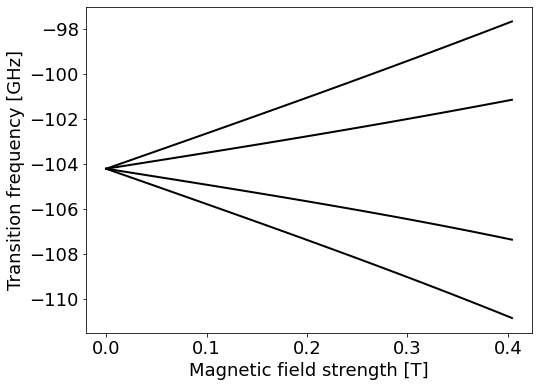

In [5]:
trans = s.sweep_B_field_transitions(B_sweep, frozen=True)

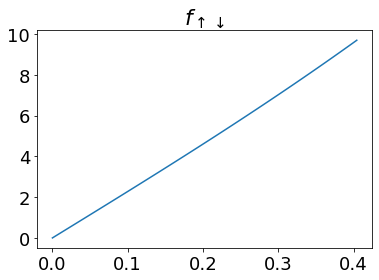

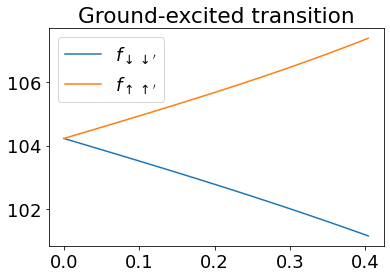

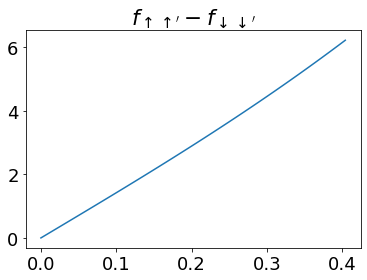

In [6]:
# Ground-ground spin transition between lowest and 2nd-lowest
gg_up_down = bands[0, :, 1] - bands[0, :, 0]
plt.title("$f_{\\uparrow\\downarrow}$")
plt.plot(np.linalg.norm(B_sweep, axis=0), gg_up_down)

# Ground-excited transition between lowest-lowest and 2nd-2nd bands (down-down, up-up)
ge_down_down = bands[0, :, 0] - bands[1, :, 0]
ge_up_up = bands[0, :, 1] - bands[1, :, 1]
plt.figure()
plt.title("Ground-excited transition")
plt.plot(np.linalg.norm(B_sweep, axis=0), ge_down_down, label="$f_{\\downarrow\\downarrow'}$")
plt.plot(np.linalg.norm(B_sweep, axis=0), ge_up_up, label="$f_{\\uparrow\\uparrow'}$")
plt.legend()

# Ground-excited transition difference between lowest-lowest and 2nd-2nd bands (up-up minus down-down)
plt.figure()
plt.title("$f_{\\uparrow\\uparrow'} - f_{\\downarrow\\downarrow'}$")
plt.plot(np.linalg.norm(B_sweep, axis=0), ge_up_up - ge_down_down)

## Parameter optimization

In [459]:
def transition_splitting_B(B):
    s = SiVObject()
    s.update_val(B=B)
    bands = np.zeros([2, 4])
    bands[0, :] = (s.Hg.eigenenergies()).real # Ground state energies
    bands[1, :] = (s.He.eigenenergies()).real # Excited state energies

    # f_downdown, f_upup
    ge_down_down = bands[1, 0] - bands[0, 0]
    ge_up_up = bands[1, 1] - bands[0, 1]
    
    return ge_up_up - ge_down_down

def plot_reflection_contrast(w_arr, B, delta):
    
    c = Cavity({"w_down": 0}) # down transition is defined to be 0 for our convention
    # Compute splitting at given field
    splitting = transition_splitting_B(B)
    # Shift splitting and detuning to given value
    c.set_params({"w_c": delta,  "w_up": splitting})
    
    ref_down = c.reflectance(w_arr, 0)
    ref_up = c.reflectance(w_arr, 1)
    contrast = abs(ref_down - ref_up)
    
    # PLot reflection spectrum
    plt.figure(figsize=[16, 6])
    plt.subplot(1, 2, 1)
    plt.title("Reflection spectrum")
    plt.plot(w_arr, ref_down, label="down")
    plt.plot(w_arr, ref_up, label="up")

    # Plot reflection contrast 
    plt.subplot(1, 2, 2)
    plt.title("Reflection contrast spectrum")
    plt.plot(w_arr, contrast)
    plt.ylim([0, 1])
    print("Maximum contrast = {}".format(max(contrast)))
    
def max_contrast(B, delta):
    B = [B, 0 , 0] # TODO: here we assume B is always along X 
    w_arr = np.linspace(-5, 5, 1000) # TODO: Make variable, probably depend on detuning?
    
    c = Cavity({"w_down": 0}) # Down transition is defined to be 0 for our convention
    splitting = transition_splitting_B(B) # Compute splitting at given field
    c.set_params({"w_c": delta,  "w_up": splitting}) # Set the computed splitting
    contrast = abs(c.reflectance(w_arr, 0) - c.reflectance(w_arr, 1)) # Contrast defined as the difference TODO
    return max(contrast) # Maximum of contrast over the laser frequency spectrum

Maximum contrast = 0.8251894379360325
Max contrast = 0.8251894379360325, at field = 0.13333333333333333


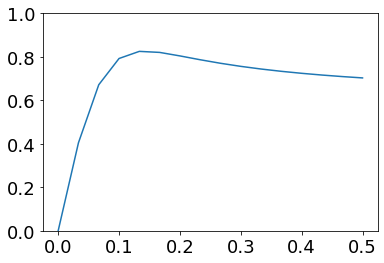

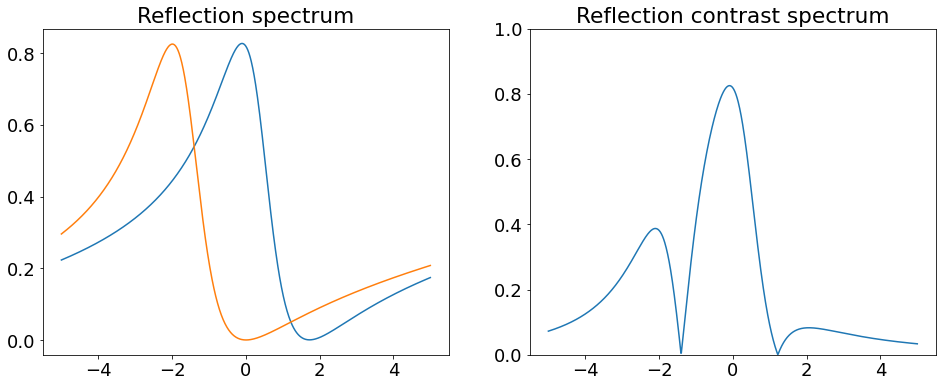

In [461]:
w_arr = np.linspace(-5, 5, 1000)
delta = -0.5 * 33 # Make variable

B_arr = np.linspace(0, 0.5, 16)
contrast = [max_contrast(B, delta) for B in B_arr]
    
plt.plot(B_arr, contrast)
plt.ylim([0, 1])

plot_reflection_contrast(w_arr, [B_arr[np.argmax(contrast)], 0, 0], delta)
print("Max contrast = {}, at field = {}".format(max(contrast), B_arr[np.argmax(contrast)]))

In [467]:
opt = minimize(lambda args: -max_contrast(args[0], args[1]), x0=[0.1, -15])
B_opt, delta_opt = opt.x
contrast_opt = -opt.fun # Negative since we used minimize()
print("Optimum contrast of {} achieved at B = {} and delta = {}".format(contrast_opt, B_opt, delta_opt))

Optimum contrast of 0.840360923350604 achieved at B = 0.07359343296836232 and delta = -40.118359199247536


Maximum contrast = 0.840360923350604


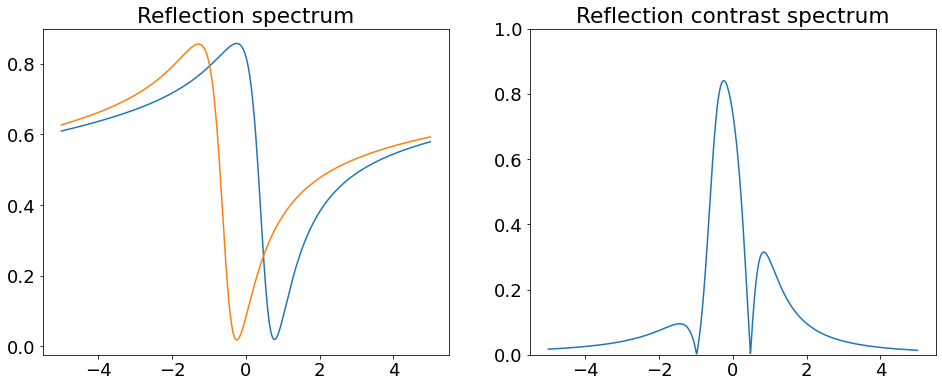

In [468]:
plot_reflection_contrast(w_arr, [B_opt, 0, 0], delta_opt)